In [1]:
import pandas as pd
from prophet import Prophet

In [2]:
data = pd.read_excel('Final Dataset.xlsx', index_col=0)

In [3]:
# separate exogenous variables for all companies from the prices volumes and tradig ranges

exogenous = data[['Close_1YBond', 'Close_10YBond', 'Unemployment rate', 'Money supply (M2)', 
    'Reference rate', 'CPI',
    'GDP per capita USD', 'Close_EUR/PLN', 'Close_Gold', 'Close_Oil',
    'Close_USD/PLN', 'Close_VIX']]

stocks = data.loc[:, :'Trading range_sWIG80']

In [4]:
pko = stocks['Close_PKO']
pko_exo = pd.concat((stocks[['Volume_PKO', 'Trading range_PKO']],exogenous), axis=1)

In [5]:
df = pko.reset_index()
df.columns = ['ds', 'y']

In [6]:
m = Prophet(changepoint_range=0.9)
m.fit(df)

14:10:27 - cmdstanpy - INFO - Chain [1] start processing
14:10:28 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1648,2020-12-25
1649,2020-12-26
1650,2020-12-27
1651,2020-12-28
1652,2020-12-29


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1648,2020-12-25,26.122311,16.004281,35.878009
1649,2020-12-26,26.930330,16.625980,37.385848
1650,2020-12-27,26.956067,17.146724,36.919971
1651,2020-12-28,26.215796,16.025763,36.264066
1652,2020-12-29,26.281456,15.757596,36.280202


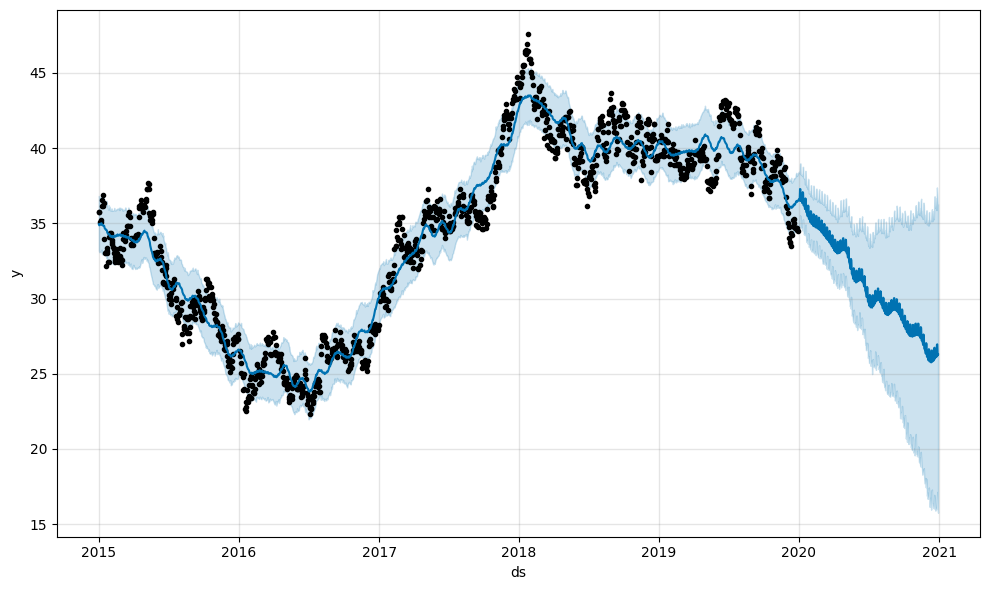

In [9]:
fig1 = m.plot(forecast)

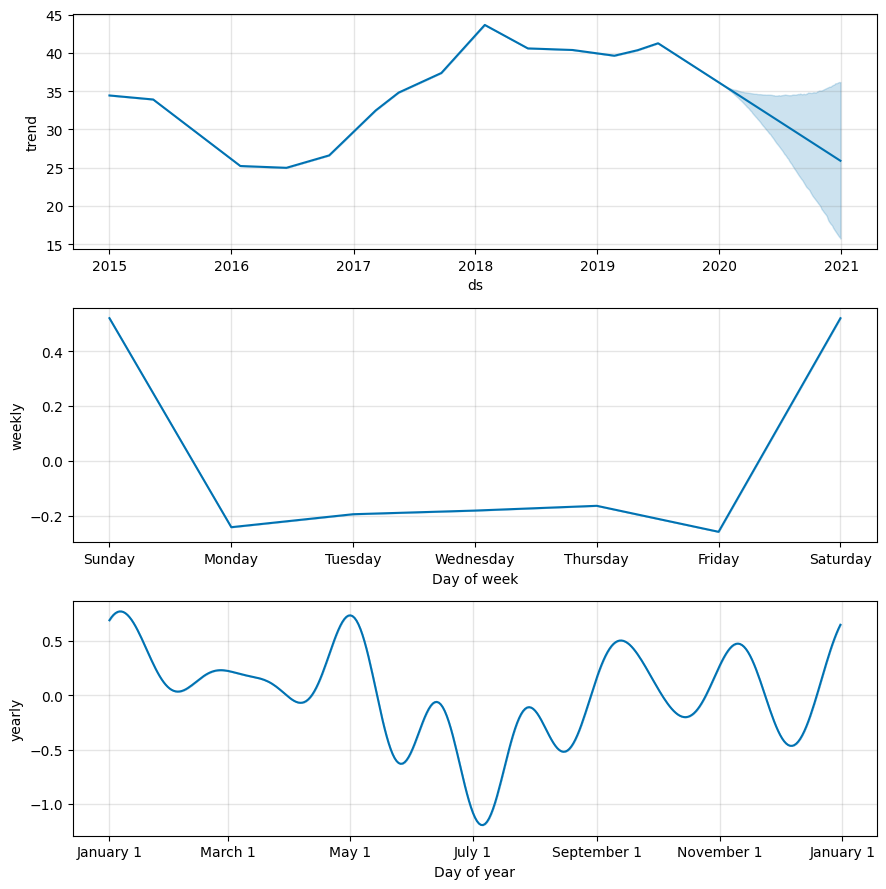

In [10]:
fig2 = m.plot_components(forecast)

In [11]:
# Python
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

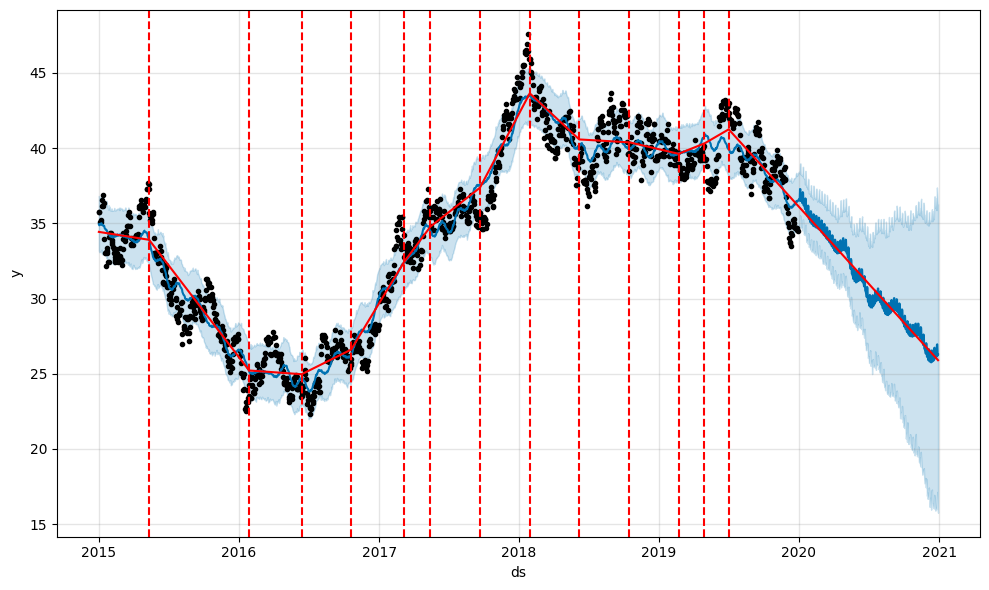

In [12]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


14:10:30 - cmdstanpy - INFO - Chain [1] start processing
14:10:30 - cmdstanpy - INFO - Chain [1] done processing


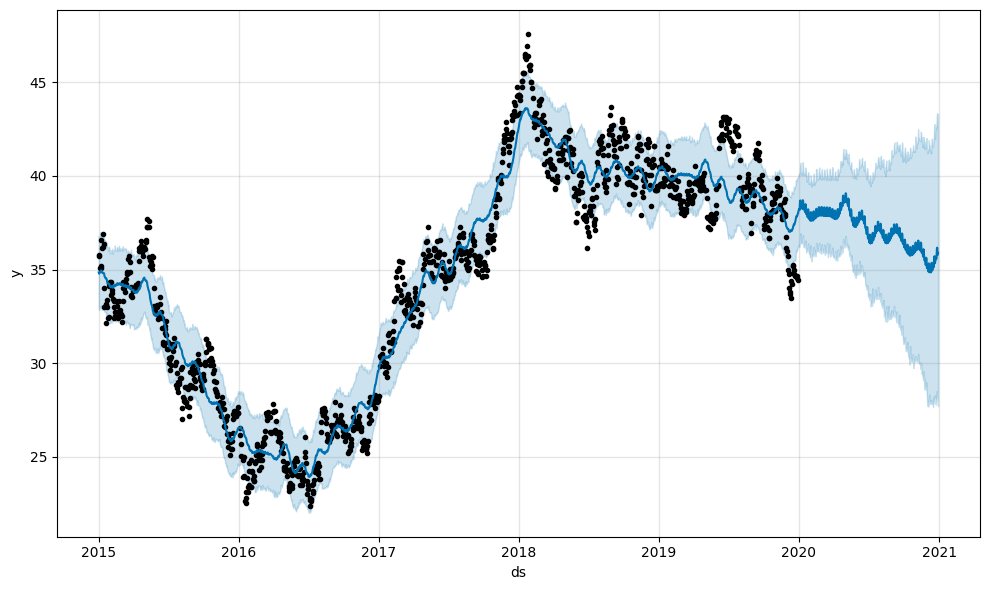

In [13]:
m = Prophet(changepoint_prior_scale=0.05)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

14:10:31 - cmdstanpy - INFO - Chain [1] start processing
14:10:31 - cmdstanpy - INFO - Chain [1] done processing


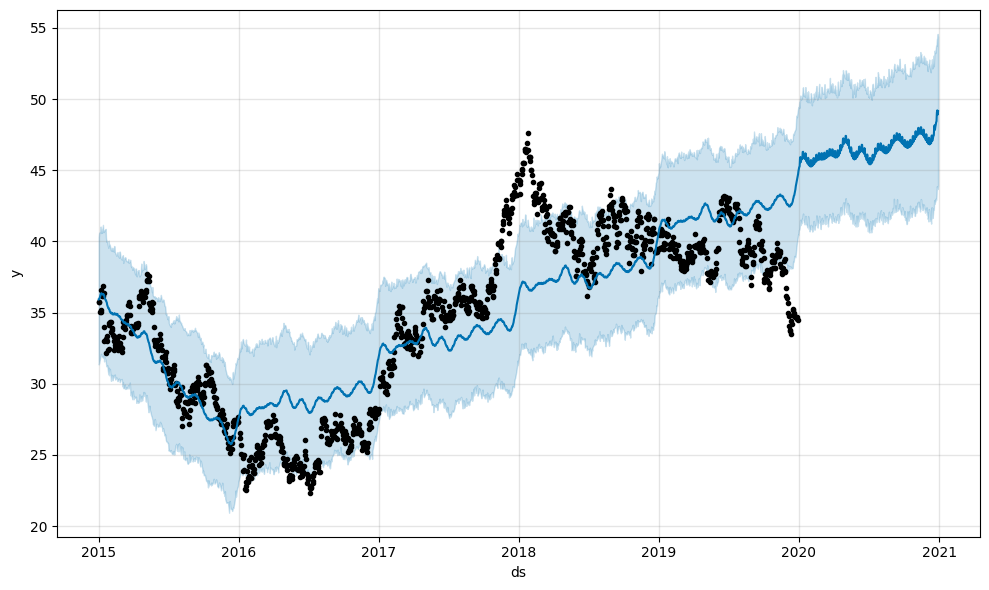

In [14]:
m = Prophet(changepoints=['2016-01-01'])
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

Look into different changepoints 

In [15]:
# Python
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime([
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2016-02-07', '2018-02-02']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [16]:
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)


14:10:32 - cmdstanpy - INFO - Chain [1] start processing
14:10:32 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
7,2015-01-12,-1.444252,0.000000
270,2016-01-18,-1.444252,0.000000
275,2016-01-25,-1.444252,0.000000
285,2016-02-08,-1.444252,0.084412
791,2018-02-02,0.000000,1.976812


In [18]:
m = Prophet()
m.add_country_holidays(country_name='PL')
m.fit(df)

14:10:32 - cmdstanpy - INFO - Chain [1] start processing
14:10:33 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
m.train_holiday_names


0                                    New Year's Day
1                                          Epiphany
2                                     Easter Sunday
3                                     Easter Monday
4                                      National Day
5                  National Day of the Third of May
6                                         Pentecost
7                                    Corpus Christi
8                                    Assumption Day
9                                   All Saints' Day
10                        National Independence Day
11                                    Christmas Day
12                          Second Day of Christmas
13    National Independence Day - 100th anniversary
dtype: object

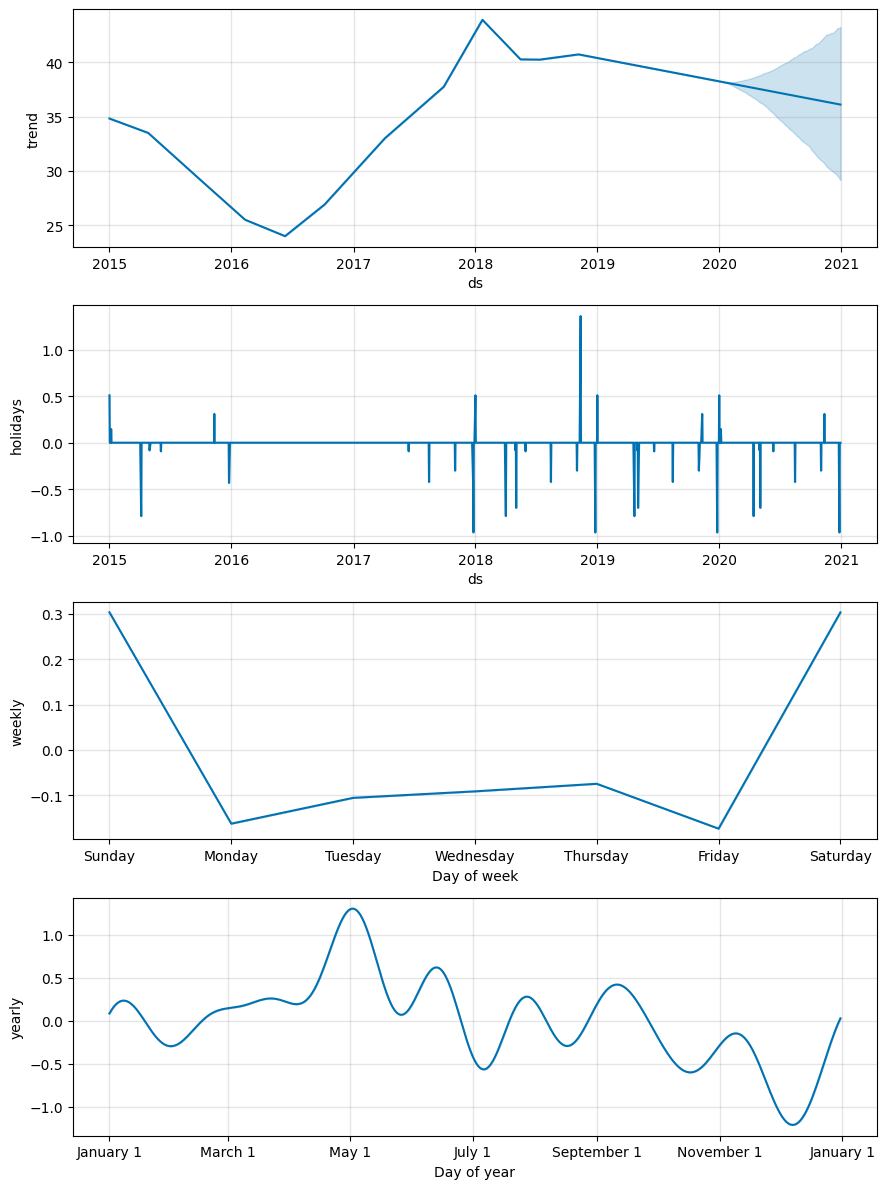

In [20]:
forecast = m.predict(future)
fig = m.plot_components(forecast)


14:10:34 - cmdstanpy - INFO - Chain [1] start processing
14:10:34 - cmdstanpy - INFO - Chain [1] done processing


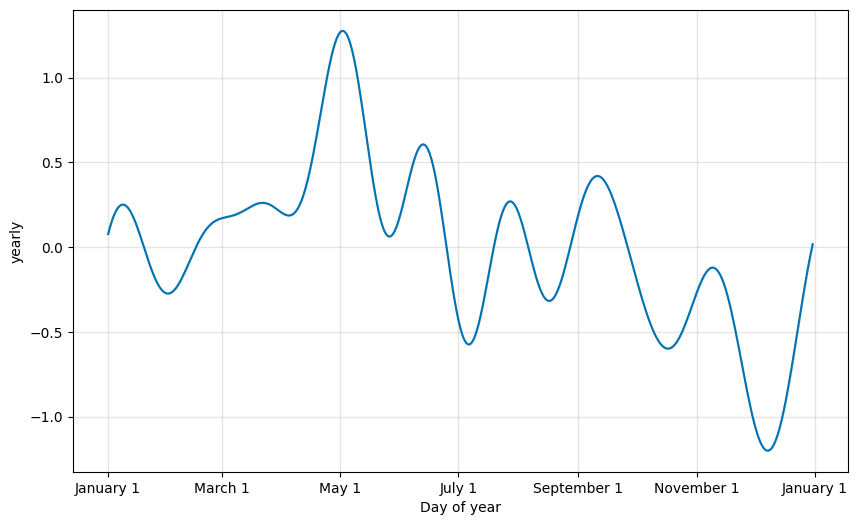

In [21]:
from prophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

14:10:34 - cmdstanpy - INFO - Chain [1] start processing
14:10:34 - cmdstanpy - INFO - Chain [1] done processing


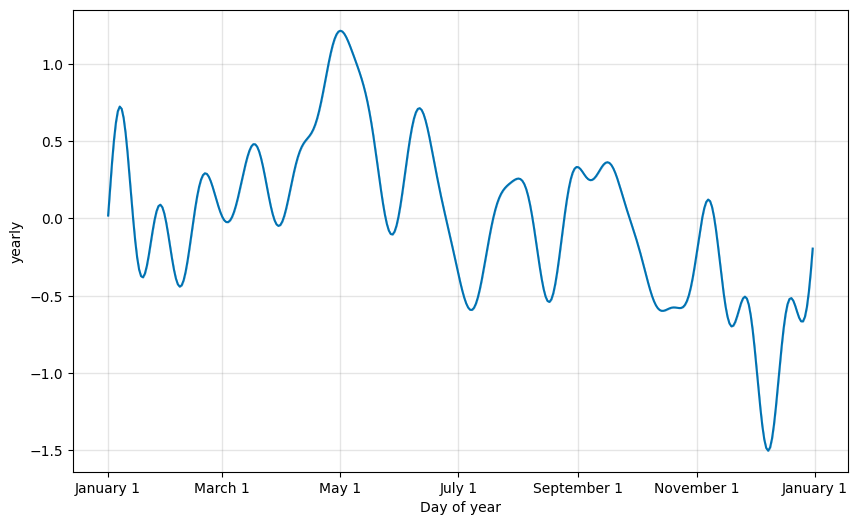

In [22]:
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

14:10:35 - cmdstanpy - INFO - Chain [1] start processing
14:10:35 - cmdstanpy - INFO - Chain [1] done processing


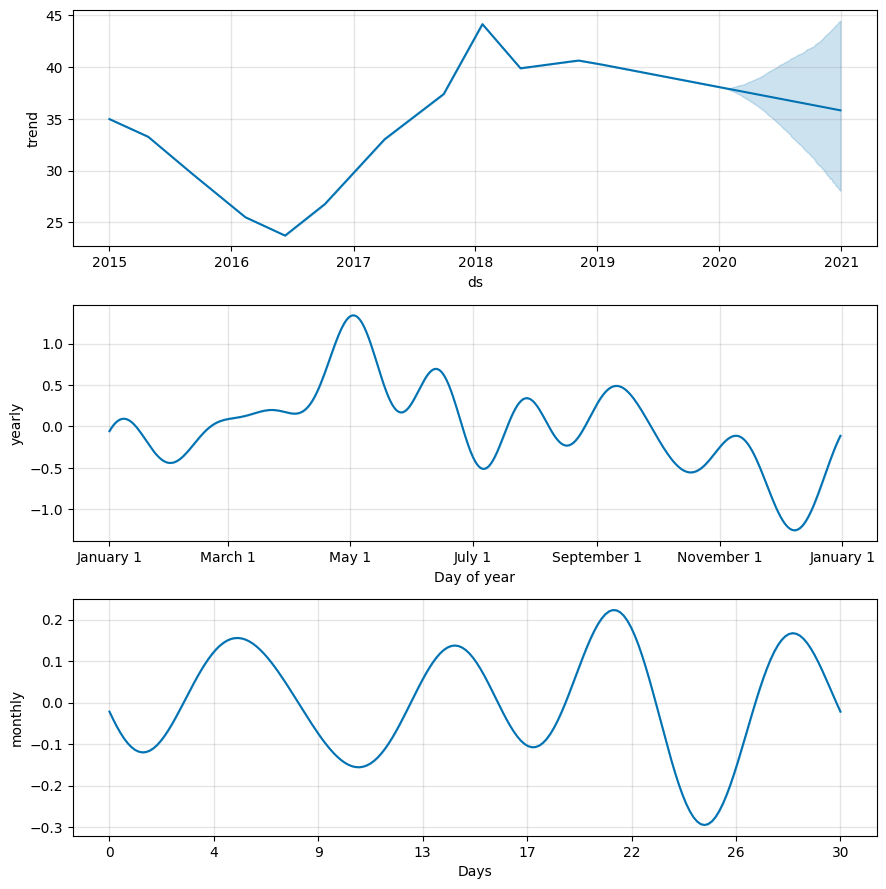

In [23]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

In [24]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)

14:10:36 - cmdstanpy - INFO - Chain [1] start processing
14:10:36 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,34.822840,32.870942,36.842468,34.822840,34.822840,0.001699,0.001699,0.001699,0.0,...,-0.085299,-0.085299,-0.085299,0.086998,0.086998,0.086998,0.0,0.0,0.0,34.824540
1,2015-01-02,34.811622,32.796528,36.804577,34.811622,34.811622,-0.050371,-0.050371,-0.050371,0.0,...,-0.187139,-0.187139,-0.187139,0.136768,0.136768,0.136768,0.0,0.0,0.0,34.761251
2,2015-01-05,34.777969,32.935397,36.872858,34.777969,34.777969,0.105289,0.105289,0.105289,0.0,...,-0.146748,-0.146748,-0.146748,0.252036,0.252036,0.252036,0.0,0.0,0.0,34.883257
3,2015-01-06,34.766751,32.963713,36.951497,34.766751,34.766751,0.165658,0.165658,0.165658,0.0,...,-0.112571,-0.112571,-0.112571,0.278229,0.278229,0.278229,0.0,0.0,0.0,34.932408
4,2015-01-07,34.755533,32.902377,36.738699,34.755533,34.755533,0.197242,0.197242,0.197242,0.0,...,-0.100821,-0.100821,-0.100821,0.298063,0.298063,0.298063,0.0,0.0,0.0,34.952774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648,2020-12-25,36.147831,27.894027,42.631796,28.563454,43.241753,-0.522607,-0.522607,-0.522607,0.0,...,-0.187139,-0.187139,-0.187139,-0.335467,-0.335467,-0.335467,0.0,0.0,0.0,35.625224
1649,2020-12-26,36.141968,28.664526,43.489015,28.522735,43.254680,0.053450,0.053450,0.053450,0.0,...,0.316289,0.316289,0.316289,-0.262839,-0.262839,-0.262839,0.0,0.0,0.0,36.195418
1650,2020-12-27,36.136105,28.218036,43.536395,28.480985,43.292434,0.124281,0.124281,0.124281,0.0,...,0.316289,0.316289,0.316289,-0.192008,-0.192008,-0.192008,0.0,0.0,0.0,36.260386
1651,2020-12-28,36.130242,28.418554,43.315880,28.438869,43.318351,-0.270406,-0.270406,-0.270406,0.0,...,-0.146748,-0.146748,-0.146748,-0.123659,-0.123659,-0.123659,0.0,0.0,0.0,35.859835


In [1]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

: 

In [26]:
model = Prophet(growth='logistic', # or 'linear'
                n_changepoints=25, # change number of changepoints to include
                changepoint_range=0.9, # Proportion of history in which to look for changepoints
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                seasonality_mode='multiplicative', # or 'additive' 
                seasonality_prior_scale=10.0,
                holidays_prior_scale=10.0,
                changepoint_prior_scale=0.05,
                mcmc_samples=300,
                interval_width=0.95,
                uncertainty_samples=1000,
                stan_backend='CMDSTANPY' # or 'PYSTAN'
                )

# make it so we are u sing a rolling window 
df_cv = cross_validation(
    model=model,            # Your trained Prophet model
    initial='1460 days',    # Use the first 4 years (4 * 365 days) for training
    horizon='1 day',        # Forecast the next 1 day
    period='1 day'          # Move cutoff forward by 1 day each time
)

# think about outliers
